<a href="https://colab.research.google.com/github/berviantoleo/machine-learning-experiment/blob/master/Submission_2_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
data_train

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,23.200000,52.200000,22.433333,1.000000,24.500000,44.295714,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [ ]:
data_train.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

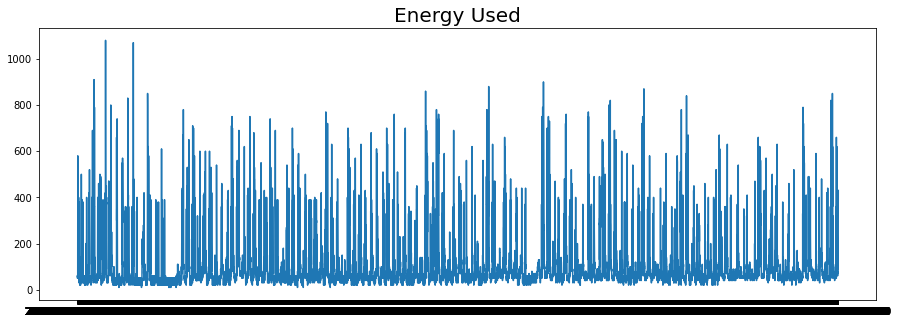

In [ ]:
dates = data_train['date'].values
energy  = data_train['Appliances'].values
     
plt.figure(figsize=(15,5))
plt.plot(dates, energy)
plt.title('Energy Used',
              fontsize=20);

In [ ]:
# preproccess - normalize
# scaler = MinMaxScaler(feature_range=(0, 1))
# energy_normalize = scaler.fit_transform(energy.reshape(1,-1))
# energy_norm = energy_normalize[0]
# energy_norm

train_size = int(len(energy) * 0.8)
test_size = len(energy) - train_size
train, test = energy[0:train_size], energy[train_size:len(energy)]
print(len(train),len(test))

15788 3947


In [ ]:
minimum = min(train)
maximum = max(train)
print(minimum,maximum)
lower_mae = (maximum - minimum) / 10
print(lower_mae)

10 1080
107.0


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(train.astype('float32'), window_size=60, batch_size=100, shuffle_buffer=1000)
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
val_set = windowed_dataset(test.astype('float32'), window_size=60, batch_size=100, shuffle_buffer=1000)
val_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('mae') < 45.0):
        print("\nmae sudah kurang dari 44.5!")
        self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, callbacks=[callbacks], validation_data=val_set, epochs=100)

Epoch 1/100
158/158 [==============================] - 17s 108ms/step - loss: 95.4635 - mae: 95.9635 - val_loss: 88.1574 - val_mae: 88.6574
Epoch 2/100
158/158 [==============================] - 17s 105ms/step - loss: 70.1660 - mae: 70.6648 - val_loss: 40.9217 - val_mae: 41.4217
Epoch 3/100
158/158 [==============================] - 17s 105ms/step - loss: 51.1972 - mae: 51.6876 - val_loss: 40.5455 - val_mae: 41.0359
Epoch 4/100
158/158 [==============================] - 17s 105ms/step - loss: 50.6020 - mae: 51.0896 - val_loss: 39.8121 - val_mae: 40.3027
Epoch 5/100
158/158 [==============================] - 17s 105ms/step - loss: 48.3639 - mae: 48.8574 - val_loss: 36.3914 - val_mae: 36.8820
Epoch 6/100
158/158 [==============================] - 17s 106ms/step - loss: 45.6507 - mae: 46.1430 - val_loss: 35.9454 - val_mae: 36.4389
Epoch 7/100
158/158 [==============================] - 17s 106ms/step - loss: 45.2431 - mae: 45.7352 - val_loss: 36.3083 - val_mae: 36.8022
Epoch 8/100
158/158 

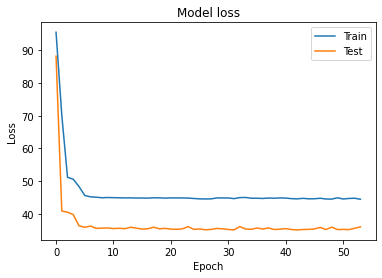

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

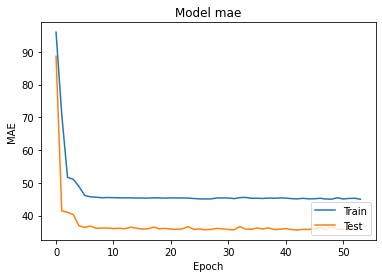

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()